In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Directory to save the dataset
dataset_dir = "caltech101"

Using device: cpu


In [3]:
# Transformations for preprocessing images
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure all images are RGB
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])


In [4]:
# Download the dataset with torchvision.datasets
caltech101_data = datasets.Caltech101(
    root=dataset_dir,
    download=True,  # Automatically download the dataset
    transform=transform  # Apply the defined transformations
)

Files already downloaded and verified


In [5]:
# Definir as proporções
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

data_size = len(caltech101_data)
train_size = int(train_ratio * data_size)
val_size = int(val_ratio * data_size)
test_size = data_size - train_size - val_size  # Garantir que o restante seja alocado para o teste

# Dividir o conjunto de dados
train_data, val_data, test_data = random_split(caltech101_data, [train_size, val_size, test_size])

# Criar DataLoaders para treino, validação e teste
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Imprimir informações dos conjuntos de dados e DataLoaders
print(f"Total dataset size: {data_size}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of classes: {len(caltech101_data.categories)}")

Total dataset size: 8677
Training set size: 6073
Validation set size: 867
Test set size: 1737
Number of classes: 101


In [6]:
# Step 2: Define the model
# Use ResNet18 for transfer learning
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(caltech101_data.categories))  # Update final layer
model = model.to(device)

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Step 3: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [8]:
# Step 4: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train and evaluate the model.
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100 * correct / total
        print(f"Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%\n")

In [9]:
# Step 5: Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

Epoch 1/5


  0%|          | 0/190 [00:00<?, ?it/s]

100%|██████████| 190/190 [03:21<00:00,  1.06s/it]


Training Loss: 1.6815, Accuracy: 60.23%
Validation Loss: 1.3477, Accuracy: 66.78%

Epoch 2/5


100%|██████████| 190/190 [02:42<00:00,  1.17it/s]


Training Loss: 0.6615, Accuracy: 82.35%
Validation Loss: 0.8169, Accuracy: 78.30%

Epoch 3/5


100%|██████████| 190/190 [02:41<00:00,  1.18it/s]


Training Loss: 0.3519, Accuracy: 89.74%
Validation Loss: 0.9002, Accuracy: 78.24%

Epoch 4/5


100%|██████████| 190/190 [02:57<00:00,  1.07it/s]


Training Loss: 0.1848, Accuracy: 94.42%
Validation Loss: 0.7490, Accuracy: 82.38%

Epoch 5/5


100%|██████████| 190/190 [02:47<00:00,  1.14it/s]


Training Loss: 0.1310, Accuracy: 96.30%
Validation Loss: 0.7439, Accuracy: 82.21%



In [12]:
# Save the trained model
torch.save(model.state_dict(), "caltech101_resnet18.pth")
print("Model saved!")

Model saved!


In [10]:
# Step 6: Test with a single image
def test_image(image_path, model, transform):
    """
    Test a single image with the trained model.
    """
    model.eval()
    from PIL import Image
    image = Image.open(image_path)  # Open the image
    plt.imshow(image)  # Display the image
    plt.axis('off')
    plt.show()

    # Apply transformations
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)

    category = caltech101_data.categories[predicted.item()]
    print(f"Prediction: {category}")

# Test the model with an example image
# Replace "example.jpg" with the path to your test image
# test_image("caltech101/test/example.jpg", model, transform)

Test Accuracy: 83.16%


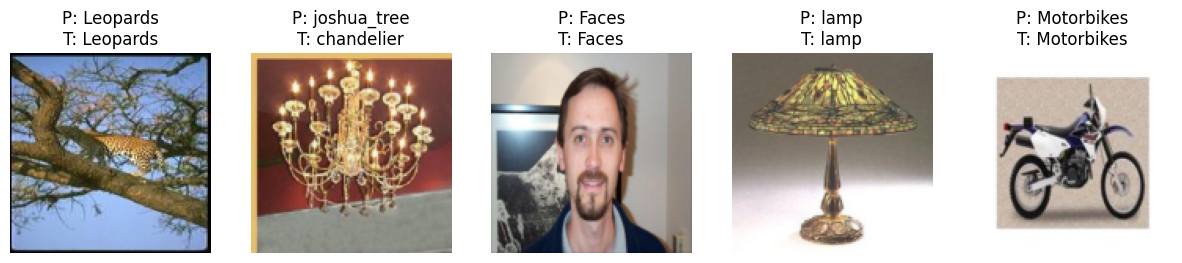

In [16]:
# Step 4: Evaluate the model on the validation/test set
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test dataset.
    """
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return predictions, true_labels

# Use the validation set as the test set
test_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Evaluate the model
predictions, true_labels = evaluate_model(model, test_loader)

# Step 5: Visualize some results
def visualize_predictions(test_data, predictions, true_labels, categories, num_images=5):
    """
    Visualize some test images along with model predictions and true labels.
    Arguments:
        test_data: The test dataset (Subset or DataLoader).
        predictions: Predicted labels by the model.
        true_labels: Ground-truth labels.
        categories: List of category names from the original dataset.
        num_images: Number of images to display.
    """
    import numpy as np
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = np.random.randint(len(test_data))  # Randomly pick an image index
        img, label = test_data[idx]  # Get image and true label
        img = img.permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(img)
        axes[i].axis("off")
        pred_label = categories[predictions[idx]]
        true_label = categories[true_labels[idx]]
        axes[i].set_title(f"P: {pred_label}\nT: {true_label}")
    plt.show()

visualize_predictions(val_data, predictions, true_labels, caltech101_data.categories)